<a href="https://colab.research.google.com/github/magicmercedes/maskrcnn-ppe-detection/blob/main/colab_ppe_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Mask-RCNN Starter Model for the PPE (Personal Protective Equipment) Detection**

---

This notebook shows how to train Mask R-CNN on PPE dataset with transfer learning in Google Colab. 

*   Using pre-trained COCO weights
*   Colab Runtime type: Python3, GPU enabled. 


**(To enable GPU in your notebook, select the following menu options −> Runtime -> Change runtime type "GPU"**


## Install required packages

Download the source code of the Mask R-CNN model and my ppe repo from github.

In [2]:
%cd

!git clone https://github.com/matterport/Mask_RCNN.git

/root
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 32.44 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [3]:
%cd ~/Mask_RCNN

!git clone https://github.com/magicmercedes/maskrcnn-ppe-detection.git

/root/Mask_RCNN
Cloning into 'maskrcnn-ppe-detection'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 124 (delta 12), reused 10 (delta 3), pack-reused 78
Receiving objects: 100% (124/124), 38.40 MiB | 29.48 MiB/s, done.
Resolving deltas: 100% (12/12), done.


### Import libraries

In [4]:
%cd ~/Mask_RCNN

# Edit requirements file for suitible keras version
!sed -i 's/keras>=2.0.8/keras==2.1.0/g' requirements.txt 

!pip install -q PyDrive
!pip install -r requirements.txt

/root/Mask_RCNN
     |████████████████████████████████| 307kB 8.8MB/s 
     |████████████████████████████████| 163kB 17.0MB/s 
     |████████████████████████████████| 204kB 17.2MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [5]:
#Selection of the correct versions of the libraries in order not to get errors.
%tensorflow_version 1.15
!pip install q keras==2.1.0 
#Run setup
!python setup.py install

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/bf/c2/b0c2ece713e754d1692aa432ad682751cd1ad6abf7500a534558b1fbfbe7/Keras-2.1.0-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running 

In [4]:
#Testing for GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Train model

Pretrained weights options are COCO.

In [6]:
%cd ~/Mask_RCNN/

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# Root directory of the project
import shutil
from tensorflow.python.keras.saving import hdf5_format

shutil.move("/root/Mask_RCNN/maskrcnn-ppe-detection/ppe.py", "/root/Mask_RCNN/ppe.py")

ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples\\PPE_detection\\"))  # To find local version
import ppe

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs\\custom")
DATA_DIR = os.path.join(ROOT_DIR,"/root/Mask_RCNN/maskrcnn-ppe-detection/dataset")
#DATA_VAL_DIR = os.path.join(ROOT_DIR,"dataset/val")

# Local path to trained weights file
CUSTOM_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(CUSTOM_MODEL_PATH):
    utils.download_trained_weights(CUSTOM_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print(ROOT_DIR)

/root/Mask_RCNN


Using TensorFlow backend.


/
... done downloading pretrained model!
/


**Loading the Dataset**

In [7]:
 # Training dataset.
dataset_train = ppe.ppeDataset()
dataset_train.load_ppe(DATA_DIR,"train")
dataset_train.prepare()

# Validation dataset
dataset_val = ppe.ppeDataset()
dataset_val.load_ppe(DATA_DIR,"val")
dataset_val.prepare()

## Configurations


Mask R-CNN has a load of hyperparameters. I only adjust some of them.


In [8]:
class InferenceConfig(ppe.ppeConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Model



This section creates a Mask R-CNN model and specifies augmentations to be used.


In [10]:
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)
model.load_weights(CUSTOM_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
model.train(dataset_train, dataset_val,learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')

# The model is configured to log losses and save weights at the end of every epoch.
history = model.keras_model.history.history  






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.001

Checkpoint Path: /logs\custom/ppe20210314T1954/mask_rcnn_ppe_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDis

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 1.8973 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.3489 - mrcnn_bbox_loss: 0.5404 - mrcnn_mask_loss: 0.4907

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 150s 2s/step - loss: 1.8849 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.3460 - mrcnn_bbox_loss: 0.5389 - mrcnn_mask_loss: 0.4872 - val_loss: 1.4689 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 0.3583 - val_mrcnn_class_loss: 0.2494 - val_mrcnn_bbox_loss: 0.4474 - val_mrcnn_mask_loss: 0.3848
Epoch 2/10
100/100 [==============================] - 74s 743ms/step - loss: 0.9642 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.2996 - val_loss: 1.4286 - val_rpn_class_loss: 0.0253 - val_rpn_bbox_loss: 0.3989 - val_mrcnn_class_loss: 0.2518 - val_mrcnn_bbox_loss: 0.4304 - val_mrcnn_mask_loss: 0.3222
Epoch 3/10
100/100 [==============================] - 74s 739ms/step - loss: 0.7644 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1630 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.2547 - val_loss: 1.4434 - val_rpn_class_loss: 0

## Evaluation

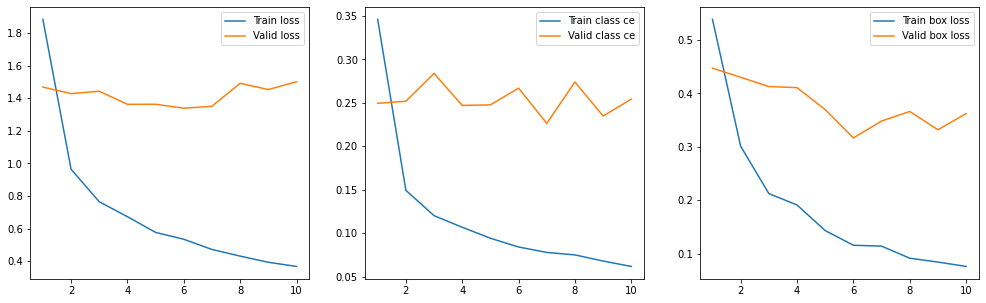

In [13]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

## Run inference on test dataset

In [16]:
class InferenceConfig(ppe.ppeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /logs\custom/ppe20210314T1954/mask_rcnn_ppe_0010.h5
Re-starting from epoch 10


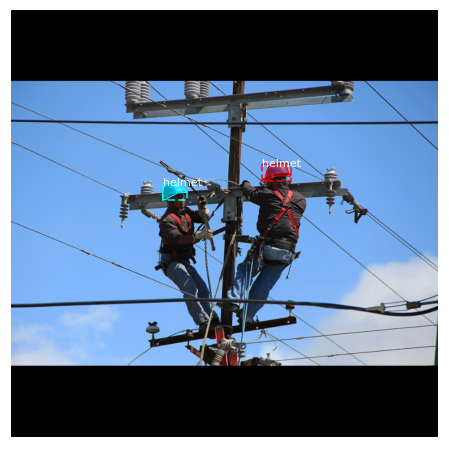

In [18]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [20]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


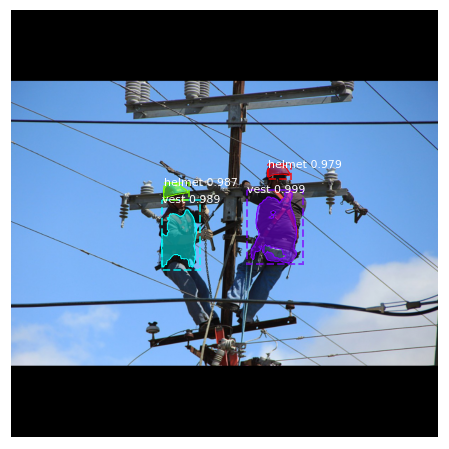

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())



## **Evaluation: mAP (mean Average Precision)**

In [22]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.5862500019371509
